In [ ]:
# 관련 패키지 import 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 

In [ ]:
# Device configuration, gpu 사용 가능한 경우 device를 gpu로 설정하고 사용 불가능하면 cpu로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 15
batch_size = 150
drop_prob = 0.2
weight_decay_lambda = 0.005
learning_rate = 0.0001

In [ ]:
# 파이토치에서 제공하는 MNIST dataset
train_dev_dataset = torchvision.datasets.MNIST(root='./data',train=True, 
                                           transform=transforms.ToTensor(), download=True)
train_dataset, dev_dataset = torch.utils.data.random_split(train_dev_dataset, [50000, 10000])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
                                          transform=transforms.ToTensor())


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# 배치 단위로 데이터를 처리해주는 Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset, 
                                         batch_size=batch_size,
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

In [ ]:
class NeuralNet(nn.Module): #weight initialization
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    torch.nn.init.kaiming_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    torch.nn.init.kaiming_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)
    self.fc3 = nn.Linear(hidden_size, num_classes)
    torch.nn.init.kaiming_normal_(self.fc3.weight)
    torch.nn.init.zeros_(self.fc3.bias)
    
    self.dropout = nn.Dropout(drop_prob)
  
  def forward(self, x): #Dropout
    out = F.relu(self.fc1(x))
    out = self.dropout(out)
    out = F.relu(self.fc2(out))
    out = self.dropout(out)
    out = self.fc3(out)
    return out

In [ ]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device) # 모델을 지정한 device로 올려줌 

In [ ]:
criterion = nn.CrossEntropyLoss() #weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay_lambda)
# model.parameters -> 가중치 w들을 의미 

In [ ]:
def evaluation(data_loader):
  correct = 0
  total = 0
  for images, labels in data_loader:
    images = images.reshape(-1, 28*28).to(device) 
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  return correct/total

In [ ]:
loss_arr = []     #early stopping
max = 0.0
total_step = len(train_loader)

In [ ]:
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    model.train()
    # Move tensors to the configured device
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad() # iteration 마다 gradient를 0으로 초기화
    loss.backward() # 가중치 w에 대해 loss를 미분
    optimizer.step() # 가중치들을 업데이트

    if (i+1) % 100 == 0:
      loss_arr.append(loss)
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
          .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
      with torch.no_grad(): # evaluate 과정 drop_out 적용하지 않음. 
          model.eval()
          acc = evaluation(dev_loader) 
          if max < acc :
              max = acc 
              print("max dev accuracy: ", max)
              torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/15], Step [100/334], Loss: 0.7908
max dev accuracy:  0.8498
Epoch [1/15], Step [200/334], Loss: 0.5796
max dev accuracy:  0.8968
Epoch [1/15], Step [300/334], Loss: 0.3588
max dev accuracy:  0.9111
Epoch [2/15], Step [100/334], Loss: 0.3470
max dev accuracy:  0.9195
Epoch [2/15], Step [200/334], Loss: 0.3709
max dev accuracy:  0.9269
Epoch [2/15], Step [300/334], Loss: 0.2775
max dev accuracy:  0.9298
Epoch [3/15], Step [100/334], Loss: 0.2409
max dev accuracy:  0.9351
Epoch [3/15], Step [200/334], Loss: 0.3694
max dev accuracy:  0.9373
Epoch [3/15], Step [300/334], Loss: 0.2220
max dev accuracy:  0.9383
Epoch [4/15], Step [100/334], Loss: 0.2924
max dev accuracy:  0.9396
Epoch [4/15], Step [200/334], Loss: 0.2827
max dev accuracy:  0.9425
Epoch [4/15], Step [300/334], Loss: 0.2392
max dev accuracy:  0.9452
Epoch [5/15], Step [100/334], Loss: 0.3357
max dev accuracy:  0.9478
Epoch [5/15], Step [200/334], Loss: 0.2237
Epoch [5/15], Step [300/334], Loss: 0.1938
Epoch [6/15], Ste

In [ ]:
with torch.no_grad():
    last_acc = evaluation(test_loader)
    print('Last Accuracy of the network on the 10000 test images : {} %'.format(last_acc*100))

    model.load_state_dict(torch.load('model.ckpt'))
    best_acc = evaluation(test_loader)
    print('Best Accuracy of the network on the 10000 test images : {} %'.format(best_acc*100))

Last Accuracy of the network on the 10000 test images : 96.06 %
Best Accuracy of the network on the 10000 test images : 96.0 %


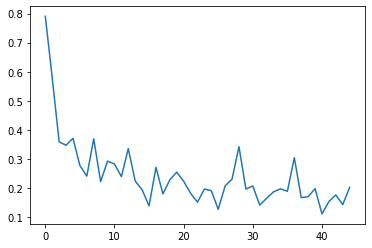

In [ ]:
plt.plot(loss_arr)
plt.show()